# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'grenoble_2019-07-17_1874823.zip'
simgrid_archives = [] #'../smpi_hpl/grenoble_2019-04-03_1858209.zip']
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[200000]


In [3]:
def get_hosts(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    hostnames = [key for key in info if '.grid5000.fr' in key]
    hostnames = [host[len('dahu-'):-len('.grenoble.grid5000.fr')] for host in hostnames]
    return list(sorted([int(host) for host in hostnames]))
get_hosts(reality_archive)

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


[2, 4, 5, 6, 7, 9, 18, 19, 21, 22, 23, 24, 25, 26, 27, 31]

In [4]:
def read_archive(archive_name, mode, exp_id):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('\tBLAS trace: %6d lines' % len(df))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df['function'] = df['function'].str.strip()
    df['mnk'] = df.m * df.n * df.k
    df['virt_node'] = df['rank'] // 32
    hosts = get_hosts(archive_name)
    hosts = pandas.DataFrame(dict(virt_node=range(len(hosts)), node=hosts)).set_index('virt_node')
    df = df.set_index('virt_node').join(hosts).reset_index()
    df['cpu'] = df['node'] * 2 + df['rank'] % 2 - 2
    return df

traces = None
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
        if mode == 'simgrid':
            installfile = get_yaml(filename, 'info.yaml')['installfile']
            install_options = get_yaml(filename, installfile)
            stochastic_cpu = install_options['stochastic_cpu']
            polynomial_dgemm = install_options['polynomial_dgemm']
            stochastic_network = install_options['stochastic_network']
            cpu = 'stochastic CPU' if stochastic_cpu else 'deterministic CPU'
            dgemm = 'polynomial DGEMM' if polynomial_dgemm else 'linear DGEMM'
            network = 'stochastic network' if stochastic_network else 'deterministic network'
            mode = 'simgrid: %s & %s & %s' % (cpu, dgemm, network)
            tmp_trace['mode'] = mode
            tmp_trace['stochastic_cpu'] = stochastic_cpu
            tmp_trace['polynomial_dgemm'] = polynomial_dgemm
            tmp_trace['stochastic_network'] = stochastic_network
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=200000)
# Mode: reality
	BLAS trace: 11434009 lines


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


,virt_node,function,start,end,rank,m,n,k,duration,mode,rank+1,mnk,node,cpu,matrix_size
0,0,smpi_marker,0.000000,0.000000,0,NaN,NaN,NaN,0.000000,reality,1,NaN,2,2,200000
1,0,dgemm,0.286809,0.286850,0,6270.0,2.0,2.0,0.000040,reality,1,25080.0,2,2,200000
2,0,dgemm,0.286931,0.286983,0,6268.0,4.0,4.0,0.000052,reality,1,100288.0,2,2,200000
3,0,dgemm,0.287045,0.287065,0,6266.0,2.0,2.0,0.000020,reality,1,25064.0,2,2,200000
4,0,dgemm,0.287139,0.287244,0,6264.0,8.0,8.0,0.000104,reality,1,400896.0,2,2,200000


## HPL result

In [5]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,200000,477.09


## Checking the parameters

In [6]:
read_csv(reality_archive, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,200000,128,32,16,1,2,2,1,0,8,32,1


## Gantt charts

In [7]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = False
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


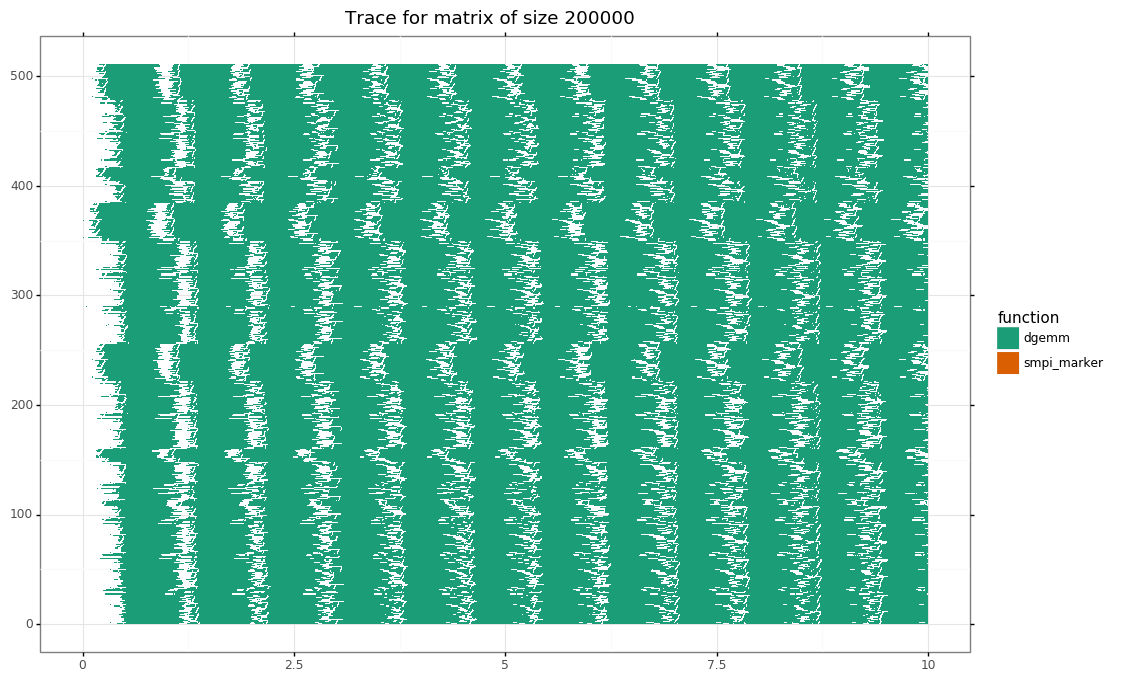

<ggplot: (8732940221532)>


In [8]:
size = traces.matrix_size.max()
tmp = traces[(traces['matrix_size'] == size)]
print(plot_bounded(tmp[tmp['mode'] == 'reality'], 0, 10, ranks=range(tmp['rank'].min(), tmp['rank'].max()), wrap=None) + ggtitle('Trace for matrix of size %d' % size))

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


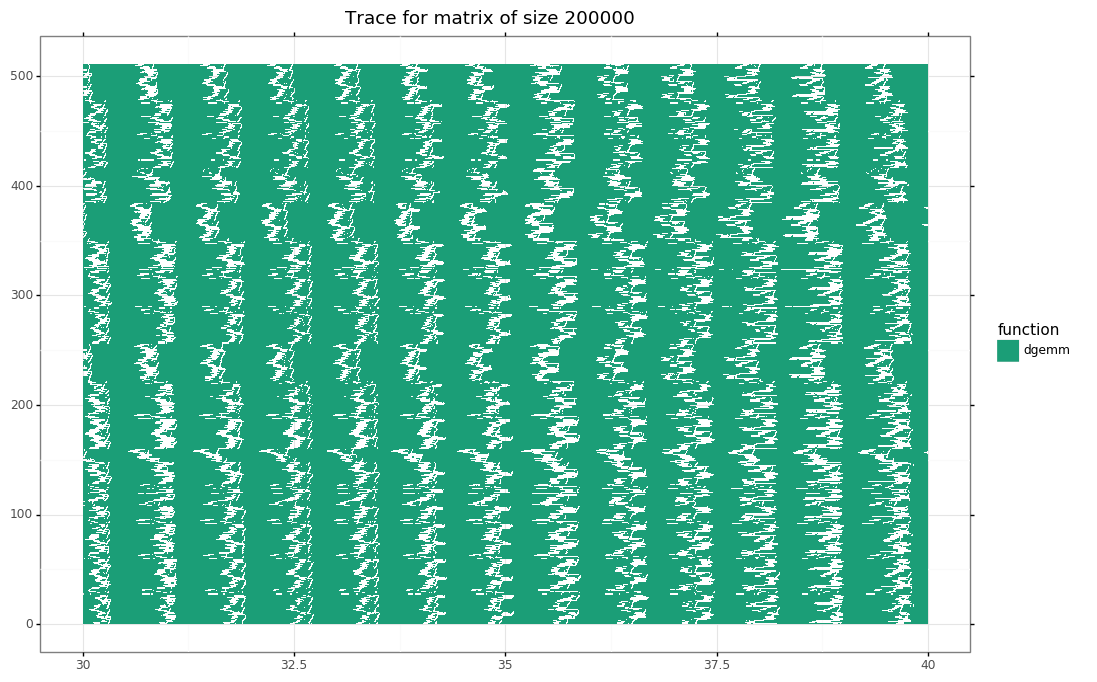

<ggplot: (8732831582998)>


In [9]:
print(plot_bounded(tmp[tmp['mode'] == 'reality'], 30, 40, ranks=range(tmp['rank'].min(), tmp['rank'].max()), wrap=None) + ggtitle('Trace for matrix of size %d' % size))

## Duration vs matrix sizes

In [10]:
stat_file = '/tmp/stats.csv'
!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv -O {stat_file}
stats = pandas.read_csv(stat_file)
min_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 4)))
max_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 5)))
stats = stats[(stats['start_time'] > min_epoch) & (stats['start_time'] < max_epoch) & (stats['cluster'] == 'dahu')]
stats['cpu'] = stats['node']*2 + stats['cpu'] - 2
print(len(stats))
stats.head()

--2019-07-18 11:27:22--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv
Résolution de gitlab.in2p3.fr… 134.158.69.41
Connexion à gitlab.in2p3.fr|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1157033 (1,1M) [text/plain]
Sauvegarde en : « /tmp/stats.csv »

/tmp/stats.csv      100%[===================>]   1,10M  --.-KB/s    ds 0,04s   

2019-07-18 11:27:22 (31,3 MB/s) — « /tmp/stats.csv » sauvegardé [1157033/1157033]

64


,function,cluster,node,cpu,jobid,start_time,avg_gflops,intercept,intercept_residual,mk,...,nk,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual
906,dgemm,dahu,8,14,1872794,1562253596,29.411034,0.000002,2.663016e-07,1.868968e-09,...,3.090713e-09,3.021082e-12,54.476653,4.088793,5.882608,1.158967,803.873722,28.583488,90.088043,0.536700
907,dgemm,dahu,8,15,1872794,1562253596,29.937655,0.000002,2.998226e-07,1.782762e-09,...,3.130368e-09,2.692329e-11,64.537640,7.550601,6.691685,1.514226,980.436894,15.627361,113.322230,9.122559
908,dgemm,dahu,9,16,1872795,1562253596,29.869229,0.000002,3.490054e-07,1.788500e-09,...,3.091349e-09,3.335459e-11,65.893017,8.494052,6.804481,0.799481,1000.791409,15.193153,113.893371,11.086900
909,dgemm,dahu,9,17,1872795,1562253596,29.936732,0.000002,3.180082e-07,1.775471e-09,...,3.084816e-09,2.859961e-11,65.921716,9.661060,6.792235,1.376712,1006.443702,23.944741,114.536584,14.429766
910,dgemm,dahu,1,0,1872787,1562253701,28.005161,0.000002,3.568280e-07,1.957824e-09,...,3.059798e-09,5.660122e-11,52.537827,1.342221,5.083726,0.406870,779.574051,19.143585,82.109109,6.597297


In [11]:
traces['pred'] = 0
traces['mnk'] = traces.m * traces.n * traces.k
traces['mn'] = traces.m * traces.n
traces['mk'] = traces.m * traces.k
traces['nk'] = traces.n * traces.k
for cpu in traces['cpu'].unique():
    reg = stats[stats['cpu'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    traces.loc[traces['cpu'] == cpu, 'pred'] += reg['intercept']
    for prod in ['mnk', 'mn', 'mk', 'nk']:
        traces.loc[traces['cpu'] == cpu, 'pred'] += reg[prod] * traces[traces['cpu'] == cpu][prod]

In [12]:
melted = traces.sample(1000000).melt(id_vars=['cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
del traces  # saving memory...

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 98 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


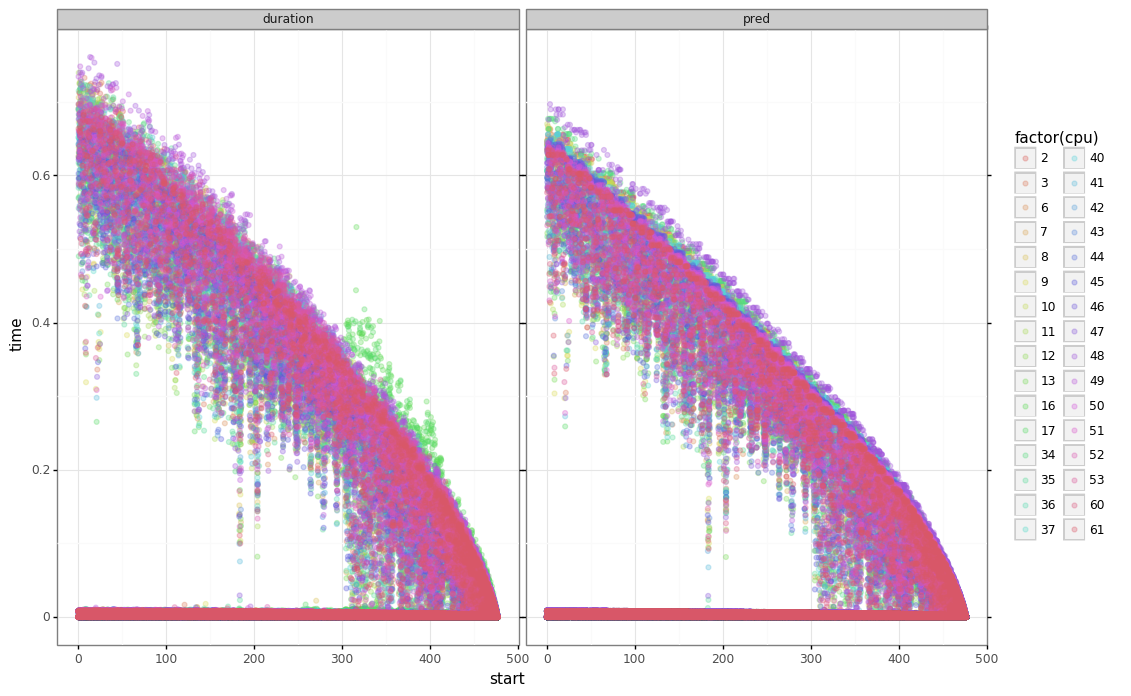

<ggplot: (8732940209991)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 98 rows 

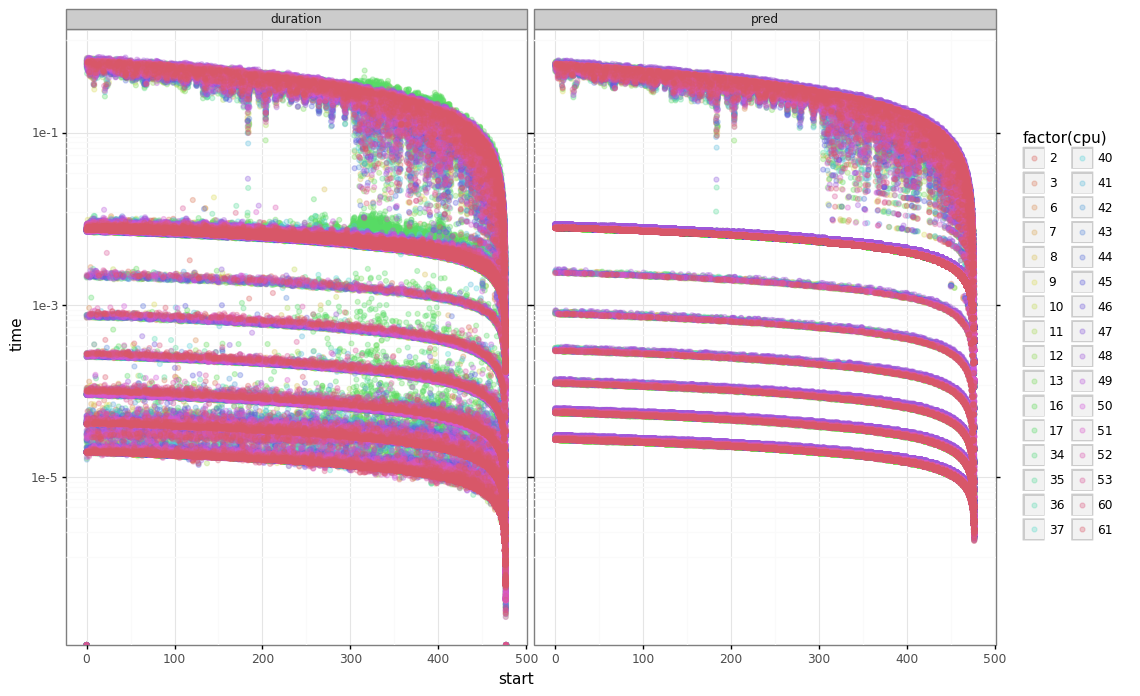

<ggplot: (8732787767609)>


In [13]:
p = ggplot(melted, aes(x='start', y='time', color='factor(cpu)')) + geom_point(alpha=0.3) + theme_bw() + facet_wrap('kind')
print(p)
print(p + scale_y_log10())

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 196 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


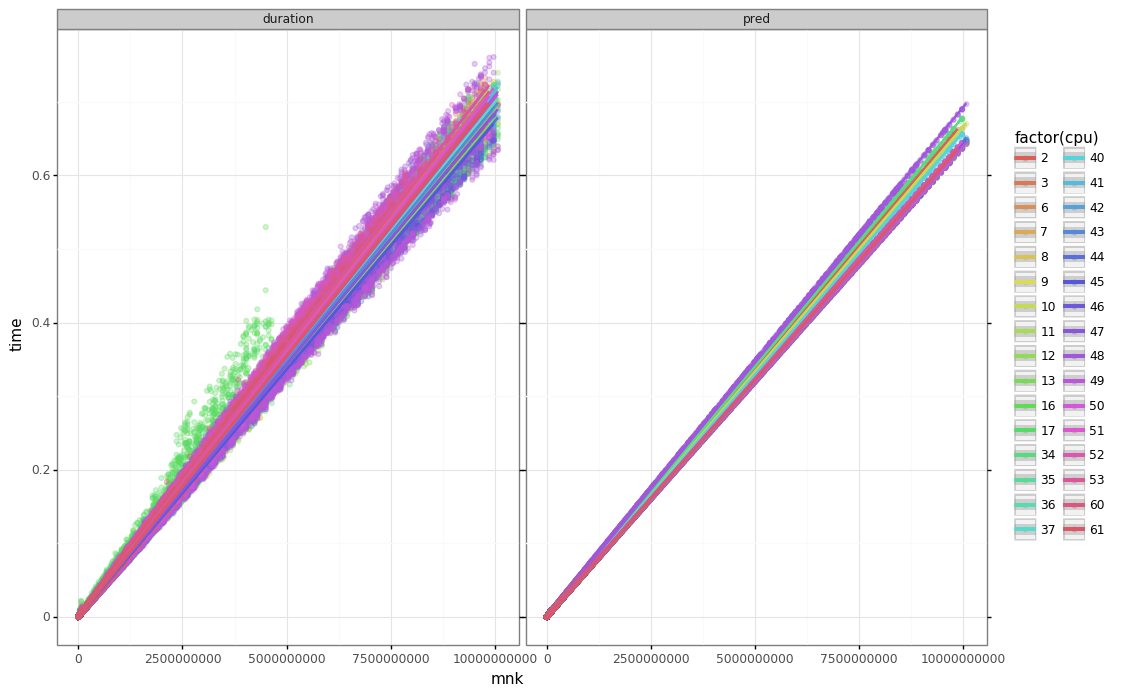

<ggplot: (-9223363304044105882)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 196 rows

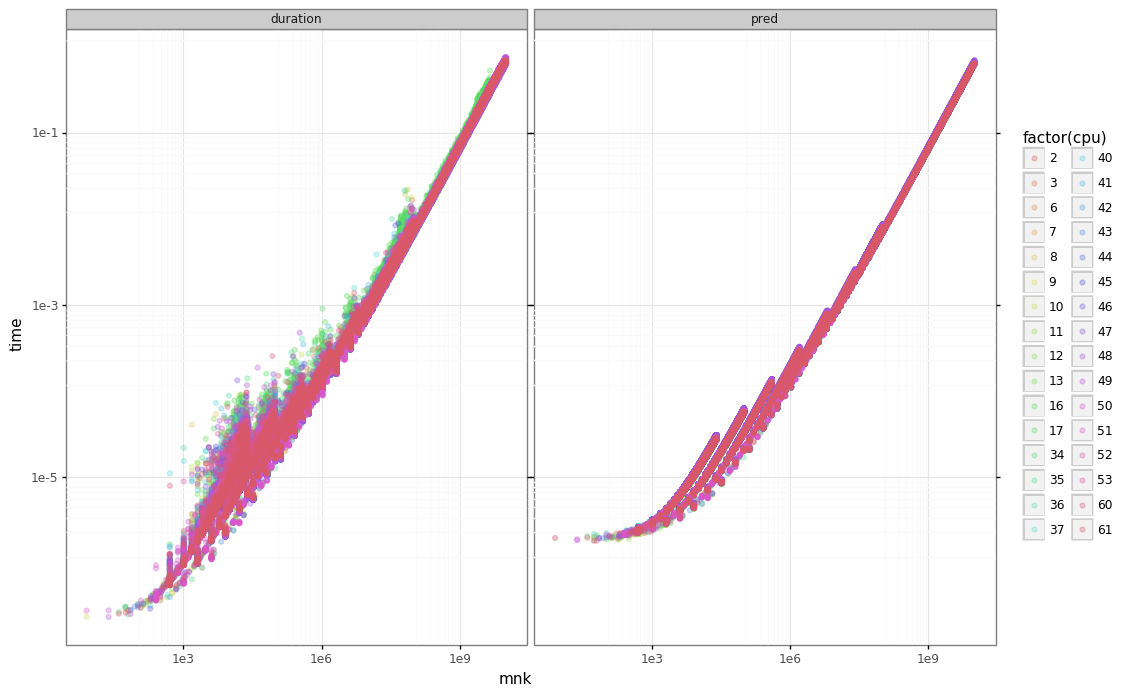

<ggplot: (-9223363304254530679)>


In [14]:
p = ggplot(melted, aes(x='mnk', y='time', color='factor(cpu)')) + geom_point(alpha=0.3) + theme_bw() + facet_wrap('kind')
print(p + geom_smooth(method='lm'))
print(p + scale_x_log10() + scale_y_log10())

In [15]:
melted[(melted['mnk'] > 2500000000) & (melted['mnk'] < 2550000000) & (melted['time'] > 0.2)].head(n=100)

,cpu,m,n,k,mnk,mn,mk,nk,start,kind,time
224432,17,3200.0,6144.0,128.0,2.516582e+09,19660800.0,409600.0,786432.0,403.9483,duration,0.255493
228074,16,3200.0,6144.0,128.0,2.516582e+09,19660800.0,409600.0,786432.0,399.4085,duration,0.216084
362709,17,3840.0,5120.0,128.0,2.516582e+09,19660800.0,491520.0,655360.0,355.8826,duration,0.202795
365472,16,3200.0,6144.0,128.0,2.516582e+09,19660800.0,409600.0,786432.0,402.0994,duration,0.249492
698680,16,3968.0,4992.0,128.0,2.535457e+09,19808256.0,507904.0,638976.0,336.3639,duration,0.225997
838025,17,3328.0,5888.0,128.0,2.508194e+09,19595264.0,425984.0,753664.0,388.3031,duration,0.220111
924931,17,3584.0,5504.0,128.0,2.524971e+09,19726336.0,458752.0,704512.0,371.5386,duration,0.207253
